In [ ]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [ ]:
dataset = datasets.CIFAR10(
    root="datasets/",
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x*2 - 1)
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

ds = Subset(dataset, range(1000))

loader = DataLoader(ds, batch_size=64, shuffle=True)

Files already downloaded and verified


In [ ]:
len(loader)*64

1024

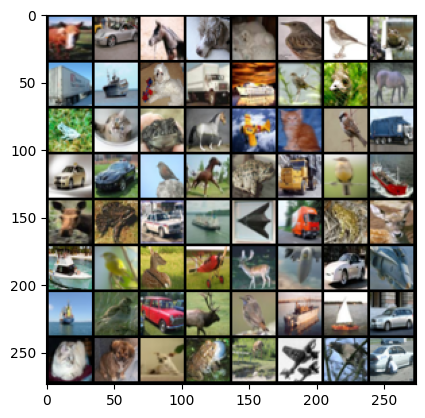

In [ ]:
x, _ = next(iter(loader))
x = x*0.5 + 0.5
grid = make_grid(x)
plt.imshow(grid.permute(1, 2, 0))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda


In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 32, 3, stride=2, padding=1),
        nn.LeakyReLU(0.1),

        nn.Conv2d(32, 64, 3, stride=2, padding=1),
        nn.LeakyReLU(0.1),

        nn.Conv2d(64, 128, 3, stride=2, padding=1),
        nn.LeakyReLU(0.1),

    )

    self.fc = nn.Linear(4*4*128, 16)

    self.mu = nn.Sequential(
        nn.Linear(16, 8),
        nn.LeakyReLU(0.1),

    )

    self.log_var_z = nn.Sequential(
        nn.Linear(16, 8),
        nn.LeakyReLU(0.1),
    )

  def forward(self, x):
    B, C, H, W = x.shape
    x = self.encoder(x)
    x = x.view(-1, 128*16)
    x = self.fc(x)
    mu = self.mu(x)
    log_var_z = self.log_var_z(x)
    eps = torch.randn(B, 8).to(device)
    z = mu + torch.exp(log_var_z) * eps
    return z, mu, log_var_z

class Upsample(nn.Module):
  def __init__(self, in_channels, out_channels, activation):
    super().__init__()
    self.block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding="same"),
        nn.Upsample(scale_factor=2),
        activation
    )

  def forward(self, x):
    return self.block(x)


class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Sequential(
        nn.Linear(8, 128*4*4)
    )

    self.decoder = nn.Sequential(
        Upsample(128, 64, nn.LeakyReLU(0.1)),
        Upsample(64, 32, nn.LeakyReLU(0.1)),
        Upsample(32, 3, nn.Tanh()),
    )

  def forward(self, z):
    z = self.fc(z)
    z = z.view(-1, 128, 4, 4)
    z = self.decoder(z)
    return y


encoder = Encoder().to(device)
decoder = Decoder().to(device)


In [ ]:
encoder.train()
decoder.train()

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=3e-4)
recon_loss_fn = nn.MSELoss()

epochs = 100

for epoch in range(epochs):
  for batch, (x, _) in enumerate(loader):
    if x.shape[0] != 64:
      continue
    x = x.to(device)
    z, mu, log_var = encoder(x)
    y = decoder(z)
    recon_loss = recon_loss_fn(y, x)
    kl_loss = -0.05 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    loss = recon_loss + kl_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"\repoch: {epoch + 1}/{epochs} batch: {batch + 1}/{len(loader)} loss: {loss.item()}", end="")

epoch: 100/100 batch: 15/16 loss: 0.23489674925804138

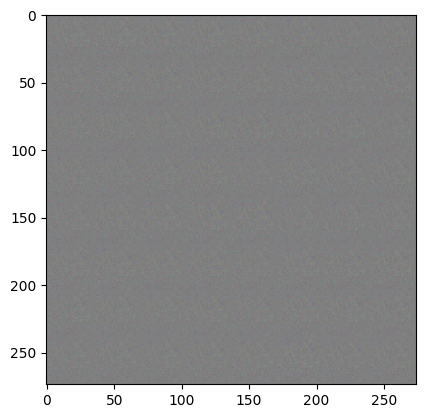

In [ ]:
decoder.eval()
with torch.no_grad():
  z = torch.randn(64, 8).to(device)
  y = decoder(z)
  grid = make_grid(y)
  plt.imshow(grid.permute(1, 2, 0).cpu()*0.5 + 0.5)